## TKO_3120 Machine Learning and Pattern Recognition

### Image recognition exercise

Faustas Butkus
faustas.f.butkus@utu.fi

March 2020

---

## Introduction

This notebook explores basic techniques of image preprocessing, data exploration, machine learning classification algorithms and comparison between them.

Three types of images are used for the input data: _sand, grass_ and _stairs_.
Links to those images are stored in separate files. <br>
All images are provided by https://unsplash.com/.

Classification algorithms used:
* K-Nearest Neighbours
* Ridge regression
* Multilayer perceptron 

In [1]:
# Libraries used throughout whole project

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Image category will be represented as an integer because machine learning algorithms require that all data are provided as numbers

In [2]:
# Numbers associated with category and the filename where urls are stored
image_categories = [
    (0, 'sand.txt'), 
    (1, 'grass.txt'), 
    (2, 'stairs.txt')
]

## Data preparation & features extraction

RGB image is stored as a matrix of pixels where each of it consists of three integers (ranging from 0 to 255) which are representations of red, green and blue colour intensities.

There are numerous ways and options to extract simple and complex features from the image. The features that are going to be used in this project are very basic ones and might not fully reflect the image, but they are quickly and easily extractable.

#### Features concerning the colours

* *Mean value of each colour channel in the image* shows how much certain colour is intensive over the all image. E.g. Image of the grass should have a high intensity of green.
* *Variance of each colour channel in the image* describes how much ranges the intensity of colour over the image. E.g. Stairs often have different lighting on them therefore the top stair will have a different shade of grey than the bottom one.

#### Features conserning the texture

To explore the texture of the image **Gray-Level-Co-Occurrence matrix (GLCM)** technique is used. It is defined by calculating the occurrence of pixel values at a given offset. Certain attributes, like *correlation*, can be calculated from the matrix. It can be defined at different angles allowing to know the texture in any direction.

* 0° and 90° correlations will be calculated with offsets of 3 and 20 px to gather the knowledge of how fast the texture changes in very small and slighly bigger distances in vertical and horizontal directions. E.g. Sand should be way smoother that stairs in vertical direction.

---

Functions for image preparation

In [3]:
from skimage import transform

def resize_img(img, shape):
    """Resize image to provided shape"""
    return transform.resize(img, shape, preserve_range=True)

def preprocess_img(img):
    """Prepare image for feature extraction"""
    
    # Resize image to uniform shape for more convenient feature extraction
    resized_image = resize_img(img, (300, 300))
    
    return resized_image 

Functions for features extraction

In [4]:
def img_channel_mean(img, channel_index):
    """Calculate colour channel mean over all image"""
    channel = img[:, :, channel_index]
    return np.mean(channel)

def img_r_mean(img):
    return img_channel_mean(img, 0)

def img_g_mean(img):
    return img_channel_mean(img, 1)

def img_b_mean(img):
    return img_channel_mean(img, 2)

def img_channel_variance(img, channel_index):
    """Calculate colour channel variance over all image"""
    channel = img[:, :, channel_index]
    return np.var(channel)

def img_r_variance(img):
    return img_channel_variance(img, 0)

def img_g_variance(img):
    return img_channel_variance(img, 1)

def img_b_variance(img):
    return img_channel_variance(img, 2) 

In [5]:
from skimage import color
from skimage.feature import texture

def glcm_correlation(img, pixel_distances, angles=[0, np.pi / 2], levels=8):
    """
    Calculates the GLCM and correlation using the matrix.
    
        Parameters:
            * img: image to calculate correlation for
            
            * pixel_distances: array of offsets to calculate the distribution over
            
            * angles: angles in radians for which to calculate matrix
            
            * levels: quantization level of the image. Lower is faster but less precise.
            
        Returns:
            correlations: numpy array made of correlations for each pixel distance
    """
    
    # GLCM requires that the image is grayscaled
    grayscaled = color.rgb2gray(img).astype(int)
    
    # Reduce the quantization level of the image
    reduced = np.floor((grayscaled / 255) * levels).astype(int)
    
    # Calculate the GLCM for the image
    glcms = texture.greycomatrix(
        image=reduced, 
        distances=pixel_distances, 
        angles=angles, 
        levels=levels, 
        normed=True, 
        symmetric=True
    )
    
    # Calculate correlation of pixel values from the matrix
    correlations = texture.greycoprops(glcms, 'correlation')
    
    # Return result as a numpy array
    return np.array([correlations[:, i] for i, _ in enumerate(pixel_distances)])

In [6]:
def extract_features(img):
    """Extract features from the image and build a vector from them"""
    
    # Calculate the correlations for the image
    correlations = glcm_correlation(img, [3, 20])
    
    # Extract horizontal and vertical correlations into separate features
    horizontal_smoothness = correlations[:, 0]
    vertical_smoothness = correlations[:, 1]
    
    # Compose the feature vector of the image
    return (
        img_r_mean(img),
        img_g_mean(img),
        img_b_mean(img),
        img_r_variance(img),
        img_g_variance(img),
        img_b_variance(img),
        *horizontal_smoothness,
        *vertical_smoothness
    )

In [8]:
# Extract features from all the images and create data set from them

from skimage import io

input_array = []

# Iterate through available categories
for cid, filename in image_categories:
    
    # Load urls from the file
    urls = np.loadtxt(filename, dtype='U150')
    
    for url in urls:
        # Download the image and extract features from it
        img = io.imread(url)
        preprocessed_img = preprocess_img(img)
        features = extract_features(preprocessed_img)
        
        # Append images features to input vector alongside associated category
        input_array.append(
            [*features, cid]
        )

In [9]:
# Create pandas DataFrame from the input array for easier analysis

feature_index = [
    'R mean',  'G mean', 'B mean', 
    'R variance', 'G variance', 'B variance', 
    'Horizontal smoothness 3px', 'Horizontal smoothness 20px',
    'Vertical smoothness 3px', 'Vertical smoothness 20px',
    'Category'
]

data_set = pd.DataFrame(input_array, columns=feature_index)

features = data_set.drop('Category', axis=1, inplace=False)
categories = data_set['Category']

features.head()

,R mean,G mean,B mean,R variance,G variance,B variance,Horizontal smoothness 3px,Horizontal smoothness 20px,Vertical smoothness 3px,Vertical smoothness 20px
0,194.776410,165.387687,142.901508,563.559045,597.253541,507.250026,0.582189,0.592732,0.194937,0.341044
1,203.179267,177.127218,141.848734,162.902561,150.384857,125.779320,0.600512,-0.013596,-0.003712,0.027062
2,209.286086,153.585664,127.026846,1664.624177,2394.619500,2224.736896,0.965525,0.853929,0.776028,0.235332
3,178.151341,127.762167,82.454480,663.540706,486.874587,362.943892,0.482018,0.473186,0.131048,0.124447
4,204.377670,185.428245,176.172585,3466.546247,3284.625045,4088.892210,0.951476,0.927518,0.917723,0.813587


Before the feature relatationship analysis and model trainig data set has to be standartized. Otherwise, data measured at different scales can corrrupt the ratios between the features and outweigh some important features. 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standartized = scaler.fit_transform(features)

features = pd.DataFrame(standartized, columns=features.columns)
features.head()

,R mean,G mean,B mean,R variance,G variance,B variance,Horizontal smoothness 3px,Horizontal smoothness 20px,Vertical smoothness 3px,Vertical smoothness 20px
0,1.455948,1.010815,0.885207,-1.046247,-1.015690,-0.798879,-1.136227,-0.834876,-1.297325,-0.552798
1,1.628542,1.301463,0.863814,-1.280732,-1.309825,-0.954126,-1.037291,-3.917267,-2.000532,-1.937579
2,1.753977,0.718619,0.562632,-0.401846,0.167360,-0.099911,0.933590,0.492969,0.759709,-1.019029
3,1.114468,0.079278,-0.343082,-0.987732,-1.088343,-0.857607,-1.677097,-1.442613,-1.523487,-1.508073
4,1.653158,1.506981,1.561278,0.652732,0.753173,0.658747,0.857733,0.867073,1.261300,1.531298


## Feature relationships

To select best performing algorithm and to optimize data set features are often explored using diverse techniques. Here are some of them: 
* *Pairplot* helps to detect which features are linearly dependent and can be optimized because they do not bring a lot of value but adds more calculations
* *Principal component analysis (PCA)* converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. Furthermore, it can help to spot early data clustering.

### Pairplots

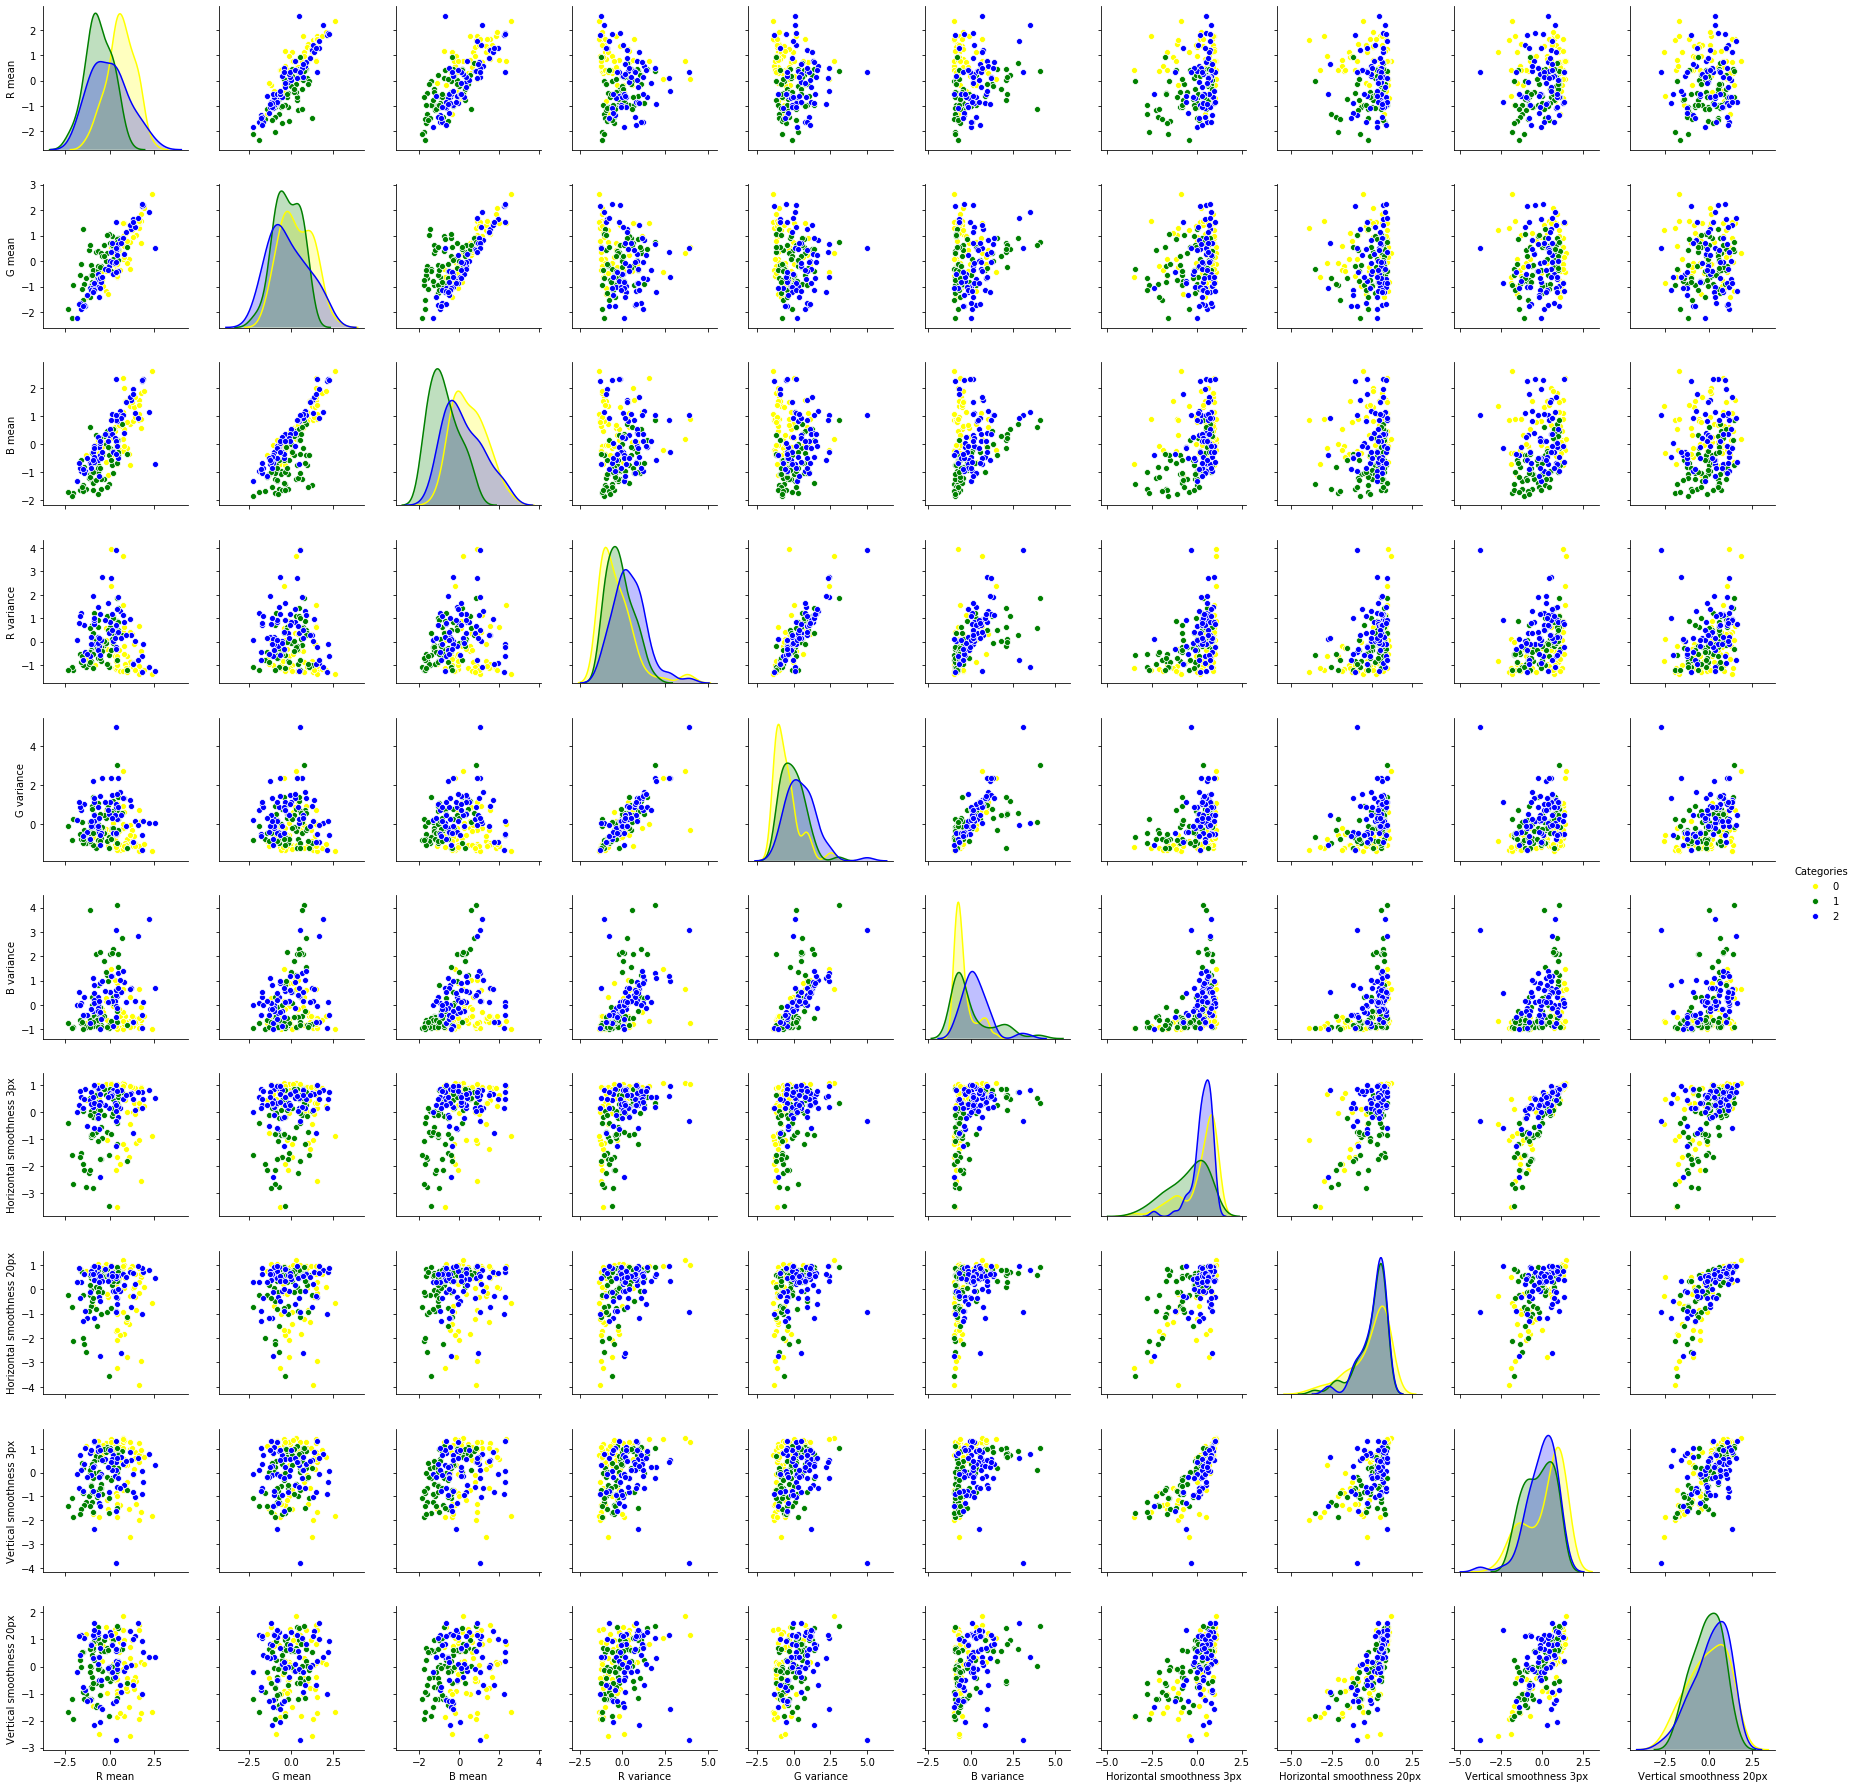

In [11]:
import seaborn as sns

# Make a copy of data set for analysis
pp_features = features.copy()
pp_features['Categories'] = categories.copy()

# Columns for drawing pairplot
variables = pp_features.columns[pp_features.columns != 'Categories']

sns.pairplot(pp_features, hue='Categories', vars=variables, palette={
    0: 'yellow', # sand
    1: 'green',  # grass
    2: 'blue'    # stairs
})

It is very noticeable that means and variances of the colours are very corellated and it is unwise to keep so highly correlated distinct features. To solve this colour channels could be replaced by grayscaled value.

Furthermore, there is slight correlation between smoothnesses so it could be optimized into one.

### Principal Component Analysis (PCA)

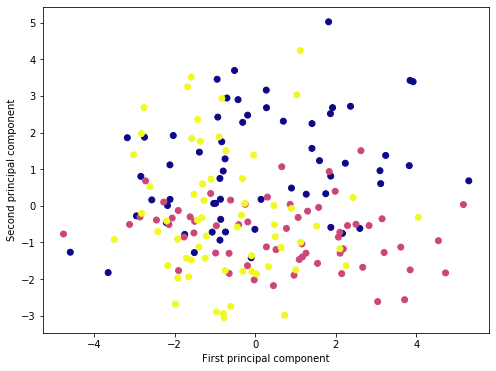

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=categories, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second principal component');

Clustering between categories is very weak and hardly noticable - data is very intermingled. This could happen because of badly selected features (sand could look simillar to stairs in orange background from the colour perspective). Trying to detect edges could help classify stairs or grass stems.

It is already predictable that the classification accuracy will not be very high.

## Classification

### Nested cross validation (Nested CV)

To achieve best classifier performance hyperparameter of classifier needs to be optimized (E.g. neighbours number in KNeighborsClassifier and etc.). Nested cross validation can be used for this purpose.

It checks each value in the given range for hyperparameter and finds the best one fitting the given data set. Furthermore, it uses provided data set very efficiently because training is done with all the data over the course.

In [13]:
from collections import namedtuple
from time import time

from sklearn.model_selection import LeaveOneOut
from tqdm.notebook import tqdm

# Convenient data structure to return the results
NestedCVResult = namedtuple('NestedCVResult', [
    'best_params', 'y_preds', 'time_took'
])

def nested_cv(params_to_try, classifier_factory, X, y):
    """
    Function to do nested cross validation in order to optimize hyperparameter (HP) of a classifier.
    It iterates through the range of parameters and does a nested cross validation with each of it.
    Best performing parameters are returned.
    
    Parameters:
    * params_to_try - array of values to try as parameters
    * classifier_factory - function which receives a value of HP and returns instanciated classifier
    * X - array of feature vectors
    * Y - array of factual values to check against
    
    Returns:
    result - tuple NestedCVResult containing:
        * best_params - array of parameters which performed best in each iteration of CV
        * y_preds - array of predicted values
        * time_took - seconds that took to do CV
    """
    
    # Try to convert data to numpy array for more convienient usage
    try:
        X, y = X.to_numpy(), y.to_numpy()
    except AttributeError:
        pass
    
    # LeaveOneOut validator splits the data in the way that each member of the data is used for verification
    loo = LeaveOneOut()

    # Best performed HP value in each iteration
    best_params = []
    
    # Predicted y value with best performing HP value
    y_preds = []

    start_time = time()
    for train_indices, test_indices in tqdm(loo.split(X), total=X.shape[0]):
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Scores of each HP value
        scores = []
        for param in params_to_try:
            
            # Calculate scores of each iteration with certain HP value
            inner_scores = []
            for subtrain_indices, subtest_indices in loo.split(X_train):
                X_subtrain, X_subtest = X_train[subtrain_indices], X_train[subtest_indices]
                y_subtrain, y_subtest = y_train[subtrain_indices], y_train[subtest_indices]

                classifier = classifier_factory(param)
                classifier.fit(X_subtrain, y_subtrain)
                
                inner_scores.append(classifier.score(X_subtest, y_subtest))
                
            # Append the mean score of certain HP value
            scores.append(np.mean(inner_scores))

        # Find the best perfoming HP value which in this iteration and save it
        best_param = params_to_try[scores.index(max(scores))]    
        best_params.append(best_param)

        # Train the classifier with best perfoming HP value and test it
        classifier = classifier_factory(best_param)
        classifier.fit(X_train, y_train)
        y_preds.append(classifier.predict(X_test))
        
    return NestedCVResult(best_params, y_preds, time() - start_time)

### Performance evaluation

In [14]:
from sklearn import metrics

#### Confusion matrix

Confusion matrix is a tool to evaluate supervised classification algorithm by visualizing correctly and incorrectly predicted data. Each row of the matrix represents the instances of a predicted class while each column represents the instances of an actual class.

In [15]:
def confusion_matrix(truth, preds):
    """Build confustion matrix from truth and predicted values"""
    return pd.DataFrame(
        metrics.confusion_matrix(truth, preds), 
        ['T: grass', 'T: sand', 'T: stairs'], 
        ['P: grass', 'P: sand', 'P: stairs']
    )

#### Accuracy score

Simple metric to check how many instances classifier guessed correctly.

In [16]:
def accuracy_score(truth, preds):
    """Calculate accuracy score from truth and predicted values"""
    return np.round(metrics.accuracy_score(truth, preds), 3)

#### Duration

Track how much time algoritmh requires to be trained.

In [17]:
import datetime

def format_seconds(seconds):
    return datetime.timedelta(seconds=int(seconds))

### Classifiers

#### K Nearest Neighbours (KNN)

K Nearest Neighbours is an algorithm that saves all the data fed to it and does not have any parameters. During the classification it calculates distance (usually Euclidian) to other data points and assigns the class which is the most common among *k* nearest neighbours.

This algorithm has hyperparameter *k* which has to be optimized. The bigger the *k* is the more clustered the data is.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn_results = nested_cv(
    range(1, 10),
    lambda k: KNeighborsClassifier(n_neighbors=k),
    features,
    categories
)

In [30]:
print('RESULTS\n')
print('-' * 30)

print(f'Training took: {format_seconds(knn_results.time_took)}')
print(f'Accuracy score: {accuracy_score(categories, knn_results.y_preds)}')
print('\nConfusion matrix:')
print(confusion_matrix(categories, knn_results.y_preds))

best_ks = knn_results.best_params
print('\nTop k values:')
for k in np.unique(best_ks):
    print(f'k = {k}, {best_ks.count(k)} times')

RESULTS

------------------------------
Training took: 0:05:24
Accuracy score: 0.73

Confusion matrix:
           P: grass  P: sand  P: stairs
T: grass         46        8          7
T: sand           6       48          8
T: stairs        10       11         41

Top k values:
k = 1, 176 times
k = 3, 1 times
k = 5, 1 times
k = 6, 7 times


As was predicted from PCA the data is hardly clustered hence it is hard for the algorithm to find clusters of data. That is why best value for hyperparamter *k* is 1. Because of that algorithm searches for single image that is the most simmilar to the test one but not for clusters of images.

#### Ridge regression

Ridge regression is a way to create a simple model with great predictive power when the number of input variables is bigger than the number of training data, or when the feature set has multicollinearity (correlations between predictor variables).

It is similar to Least squares (LS) method but works better because LS does not differentiate important and not so much predictors in a model. This leads to overfitting the model. Ridge regression adds little bias to model so that it could make more probable predictions.

The hyperparamter of Ridge regression is constant called lambda. It defines how big the penalty for LS is and how many bias should be added.

If Ridge regression performs best when lambda is 0 that means that data is pretty consistent and does not need additional biases therefore algorithm could be replaced with simple linear regression like LS.

In [26]:
from sklearn.linear_model import RidgeClassifier

ridge_results = nested_cv(
    np.arange(0.0, 5, 0.5),
    lambda alpha: RidgeClassifier(alpha),
    features,
    categories
)

In [31]:
print(f'Training took: {format_seconds(ridge_results.time_took)}')
print(f'Accuracy score: {accuracy_score(categories, ridge_results.y_preds)}')
print('\nConfusion matrix:')
print(confusion_matrix(categories, ridge_results.y_preds))

best_lambdas = ridge_results.best_params
print('\nTop lambda values:')
for l in np.unique(best_lambdas):
    print(f'lambda = {l}, {best_lambdas.count(l)} times')

Training took: 0:06:19
Accuracy score: 0.784

Confusion matrix:
           P: grass  P: sand  P: stairs
T: grass         48        1         12
T: sand           4       52          6
T: stairs        15        2         45

Top lambda values:
lambda = 0.0, 86 times
lambda = 0.5, 5 times
lambda = 1.0, 13 times
lambda = 1.5, 16 times
lambda = 2.0, 7 times
lambda = 2.5, 14 times
lambda = 3.0, 12 times
lambda = 3.5, 21 times
lambda = 4.0, 9 times
lambda = 4.5, 2 times


The best performing lambda is 0 therefore we could say that the data ratios and importance of features are pretty consistent among the data.

#### Multilayer perceptron (MLP)

A multilayer perceptron is feedforward artificial neural network.

MLP consists of at least three layers:
* Input layer - number of nodes is equal to the size of the feature vector.
* One or more hidden layers - number of layers and the neuron count in each layer are hyperparameters. They are dependent on the complexity of the data.
* Output layer - number of nodes is equal to a number of possible resulting classes.

Each node is connected to every node in the next layer. Furthermore, all the nodes, except the input nodes, uses non linear activation function which maps the weighted inputs to the output of each neuron.

MLP is trained by the technique called backpropagation which efficiently fits neural network by computing the gradient of the lost function with respect to weights for each single input-output case. 

MLP is a very powerful algorithm because it can find non-linear relations between data but it needs a lot of time and data to be trained well.

In [33]:
from sklearn.neural_network import MLPClassifier

mlp_results = nested_cv(
    [2, 30, 100, 500, 1000],
    lambda n_neurons: MLPClassifier(hidden_layer_sizes=(n_neurons), activation='relu', solver='adam', early_stopping=True),
    features,
    categories
)

In [36]:
print(f'Training took: {format_seconds(mlp_results.time_took)}')
print(f'Accuracy score: {accuracy_score(categories, mlp_results.y_preds)}')
print('\nConfusion matrix:')
print(confusion_matrix(categories, mlp_results.y_preds))

best_layer_sizes = mlp_results.best_params
print('\nTop layer sizes:')
for size in np.unique(best_layer_sizes):
    print(f'size = {size}, {best_layer_sizes.count(size)} times')

Training took: 2:10:51
Accuracy score: 0.643

Confusion matrix:
           P: grass  P: sand  P: stairs
T: grass         44        7         10
T: sand           6       41         15
T: stairs        17       11         34

Top layer sizes:
size = 500, 18 times
size = 1000, 167 times


To do later

#### MLP early stop committe

MLP early stop committe is a technique to avoid overfitting the MLPs. It works by training many (10 - 20) different MLPs in an early stop fashion. That means that  the learning is continued until the performance is no longer increasing on data outside of the training set. Another important point is that each MLP has different training and validation data set. In this way the risk of overfitting the model is almost negligible. 

## Summary

The accuracy of all algorithms is not high in general. This can be caused by very general features which do not lead to significant data clustering what can be seen in the PCA. 

The best-performed algorithm was **Ridge regression** which had an accuracy of *0,784* with optimized hyperparameter lambda equal to *0*. The success of this algorithm could be explained by the natural features linear dependency which is well exploited by this algorithm. Another advantage of this algorithm that it has parameters so you do not need to carry all the data with the model like KNN does.

The inferior accuracy of **K Nearest Neighbours** can be explained by the insufficient data clustering which is reflected by the optimized hyperparameter *k = 1*. Nevertheless, the accuracy of this algorithm is *0.73* which is not that different to **Ridge regression**.

The worst contender is **Multilayer perceptron** with the accuracy of only *0.643* and the longest nested cross-validation time which was *2:00:00* compared with **Ridge regression** which took only *0:06:19*. The failure of this algorithm can be easily explained by the lack of data, keeping in mind that MLP requires a tremendous amount of data compared to other simpler algorithms.

The accuracy of the algorithms could be improved by gathering more data and extracting more feature like:
* edge detection
* computing colour and mean variances for every colour channel
* computing GLCM correlations for more intervals